## 데이터분석과 시각화, 머신러닝 알고리즘으로 시간당 공유킥보드 대여량 예측

## 데이터 설명

  * **date** - 시간. 연-월-일 시:분:초 로 표현합니다. (가령 2011-01-01 00:00:00은 2011년 1월 1일 0시 0분 0초)
  * **businessday** - 근무일. 1이면 근무일이며, 0이면 근무일이 아닙니다.
  * **holiday** - 공휴일. 1이면 공휴일이며, 0이면 공휴일이 아닙니다.
  * **season** - 계절. 봄, 여름, 가을, 겨울 순으로 표현합니다.
  * **weather** - 날씨. 1 ~ 4 사이의 값을 가지며, 구체적으로는 다음과 같습니다.
    * 1: 맑은 날씨
    * 2: 약간의 안개와 구름이 끼어있는 날씨
    * 3: 약간의 눈, 비가 오거나 천둥
    * 4: 아주 많은 비가 오거나 우박
  * **humid** - 습도
  * **wind** - 풍속
  * **temp** - 온도
  * **sense_temp** - 체감 온도
  * **onetime** - 비회원의 공유킥보드 대여량.
  * **membership** - 멤버십에 가입한 회원의 공유킥보드 대여량.
  * **count** - 총 공유킥보드 대여랑. 비회원(onetime)과 멤버십 회원(membership)이 대여한 총 공유킥보드 대여량
  
## 프로젝트 구성
* 데이터 로드 (load data)
* 데이터 개요
* 데이터 전처리 (pre-processing)
* 모델 생성
* 검증
* 예측
* 제출 및 점수확인

## 환경설정

In [37]:
project_name = "공유 킥보드 대여량 예측" # 프로젝트 이름
class_info = "16차수 A반" # 차수 정보
email = "minhwa.lee@sk.com" # 회사 이메일
name = "이민화" # 이름 (ex. 홍길동)

## 모듈 설치 및 데이터 다운로드

In [38]:
!pip install --upgrade mySUNI -q

import mySUNI
from mySUNI import cds, utils
print('===' * 15)
print(f'패키지버전: {mySUNI.__version__}')
print('===' * 15)

utils.set_plot_error('rmsle')

project = cds.Project(project_name, class_info, email)
project.edu_name = 'mySUNI'

print(f'프로젝트명: {project_name}\n차수 정보 : {class_info}\n이  메  일: {email}')
print('===' * 15)

# 다운로드 프로젝트 파일
cds.download_project(project_name, class_info, email)

# 이메일 설정 확인
if not project.email:
    raise print("[이메일이 누락되었습니다] 이메일을 설정해 주세요↑↑↑")


프로젝트: 공유 킥보드 대여량 예측
파일 목록

submission.csv
- data/공유 킥보드 대여량 예측/submission.csv

test.csv
- data/공유 킥보드 대여량 예측/test.csv

train.csv
- data/공유 킥보드 대여량 예측/train.csv



## 모듈 import 

필요한 모듈을 import 합니다. 필요에 따라 추가 패키지를 load 할 수 있습니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 다운로드 프로젝트 파일
#cds.download_project(project_name, class_info, email)

# Data 경로 설정
DATA_DIR = 'data'

# 경고 무시
warnings.filterwarnings('ignore')

SEED=123

train = pd.read_csv(os.path.join(DATA_DIR, project_name, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, project_name, 'test.csv'))

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


NameError: name 'project_name' is not defined

2개의 데이터 셋트를 나누어 제공합니다.

1. train: 학습용 데이터 세트. 정답 값이라고 할 수 있는 `label` 값이 같이 제공됩니다.
2. test: 예측용 데이터 세트. 정답 값이 빠진 `feature` 들만 제공됩니다. 우리는 이 `feature`를 활용하여 예측을 진행합니다.

In [ ]:
test.head()

## Date : 연월일 분리 

In [ ]:
from datetime import datetime
from pandas import Series
from datetime import date

In [41]:
train['year'] = train['date'].str.split('-').str[0]
train['month'] = train['date'].str.split('-').str[1]
train['day'] = train['date'].str.split('-').str[2]
train['day'] = train['day'].str.split(' ').str[0]

In [42]:
test['year'] = test['date'].str.split('-').str[0]
test['month'] = test['date'].str.split('-').str[1]
test['day'] = test['date'].str.split('-').str[2]
test['day'] = test['day'].str.split(' ').str[0]

In [43]:
train['year'] = train['year'].astype(int)
train['month'] = train['month'].astype(int)
train['day'] = train['day'].astype(int)

In [44]:
test['year'] = test['year'].astype(int)
test['month'] = test['month'].astype(int)
test['day'] = test['day'].astype(int)

## Data : 시분 분리 

In [45]:
train['date'] = pd.to_datetime(train['date'], errors='coerce')
test['date'] = pd.to_datetime(test['date'], errors='coerce')

train['hour'] = train['date'].apply(lambda x: x.strftime('%H'))
train['hour'] = train['hour'].astype(int)
test['hour'] = test['date'].apply(lambda x: x.strftime('%H'))
test['hour'] = test['hour'].astype(int)

train['min'] = train['date'].apply(lambda x: x.strftime('%M'))
train['min'] = train['min'].astype(int)
test['min'] = test['date'].apply(lambda x: x.strftime('%M'))
test['min'] = test['min'].astype(int)

train['sec'] = train['date'].apply(lambda x: x.strftime('%S'))
train['sec'] = train['sec'].astype(int)
test['sec'] = test['date'].apply(lambda x: x.strftime('%S'))
test['sec'] = test['sec'].astype(int)

In [46]:
train['weekday'] = train['date'].apply(lambda x: x.strftime('%A'))
test['weekday'] = test['date'].apply(lambda x: x.strftime('%A'))

In [47]:
conv_week = {
    'Saturday':6,
    'Sunday':0,
    'Monday':1,
    'Tuesday':2,
    'Wednesday':3,
    'Thursday':4,
    'Friday':5,
}

In [48]:
train['weekday'] = train['weekday'].map(conv_week)
test['weekday'] = test['weekday'].map(conv_week)

## 다중공선성 - feature간에 상관도 분석

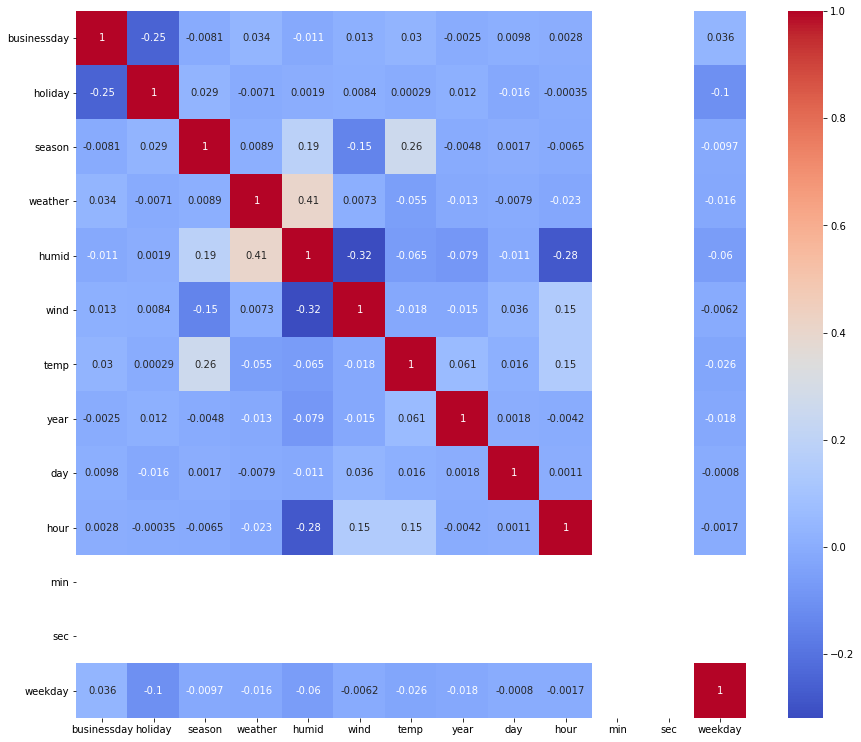

In [89]:
plt.figure(figsize=(15, 13))
sns.heatmap(x.corr(), annot=True, cmap='coolwarm')

## PCA 유사 feature 통합

In [49]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [50]:
train['temp'] = StandardScaler().fit_transform(train.loc[:, 'temp': 'sense_temp'])
test['temp'] = StandardScaler().fit_transform(test.loc[:, 'temp': 'sense_temp'])

In [51]:
train['season'] = StandardScaler().fit_transform(train.loc[:, ['season','month']])
test['season'] = StandardScaler().fit_transform(test.loc[:, ['season','month']])

## 상관도 높은 Feautres 제거 및 모델링 데이터 준비

In [52]:
features = [
#     'date', 
    'businessday', 
    'holiday',
    'season', 
    'weather', 
    'humid', 
    'wind',
    'temp', 
#     'sense_temp',
    'year',
#     'month',
    'day',
    'hour',
    'min',
    'sec',
    'weekday'
#     'time'
]

In [53]:
x = train[features]
x.head()

,businessday,holiday,season,weather,humid,wind,temp,year,day,hour,min,sec,weekday
0,0,0,-1.349864,1,81,0.0,-1.333661,2011,1,0,0,0,6
1,0,0,-1.349864,1,80,0.0,-1.438907,2011,1,1,0,0,6
2,0,0,-1.349864,1,80,0.0,-1.438907,2011,1,2,0,0,6
3,0,0,-1.349864,1,75,0.0,-1.333661,2011,1,3,0,0,6
4,0,0,-1.349864,1,75,0.0,-1.333661,2011,1,4,0,0,6


In [54]:
# log 변환 STEP 1)
y = np.log1p(train['count'])
y.head()

0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: count, dtype: float64

In [25]:
y_one = np.log1p(train['onetime'])
y_mem = np.log1p(train['membership'])
y_one.head()

0    1.386294
1    2.197225
2    1.791759
3    1.386294
4    0.000000
Name: onetime, dtype: float64

In [55]:
from sklearn.model_selection import train_test_split

SEED = 123

x_train, x_valid, y_train, y_valid = train_test_split(x, y, random_state=SEED)

In [27]:
x_train, x_valid, y_train_one, y_valid_one = train_test_split(x, y_one, random_state=SEED)
x_train, x_valid, y_train_mem, y_valid_mem = train_test_split(x, y_mem, random_state=SEED)

## 평가지표 (RMSLE)

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

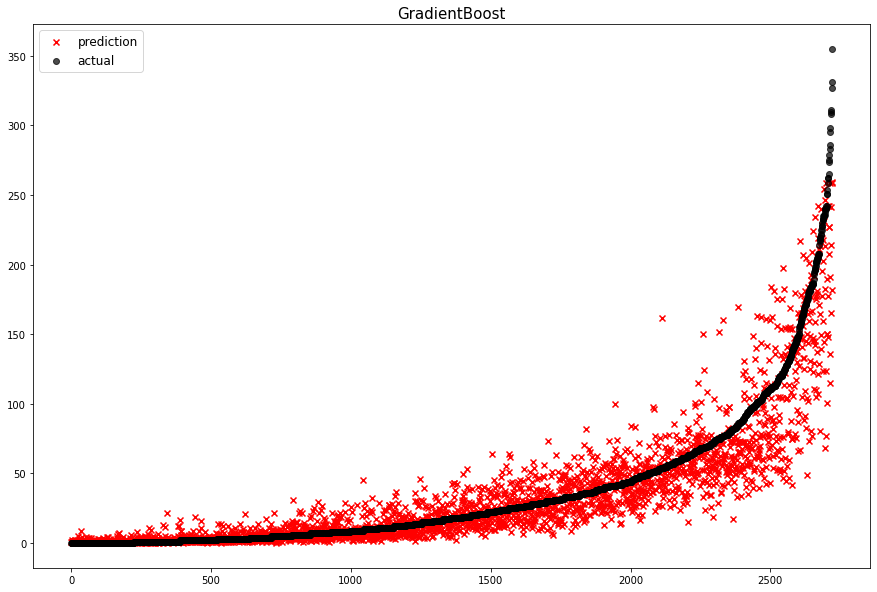

           model     error
0  GradientBoost  0.532869


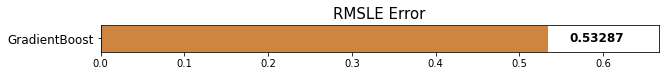

0.5328689462124694

In [28]:
gbr = GradientBoostingRegressor(random_state=SEED)
gbr.fit(x_train, y_train)
pred = gbr.predict(x_valid)
utils.plot_error('GradientBoost', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid_one), np.expm1(pred))

In [51]:
# XG_boost
model = XGBRegressor(random_state=SEED, n_jobs=1)
model.fit(x_train, y_train)
pred = model.predict(x_valid)
utils.plot_error('XGBoost', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid_one), np.expm1(pred))

-1.7625523

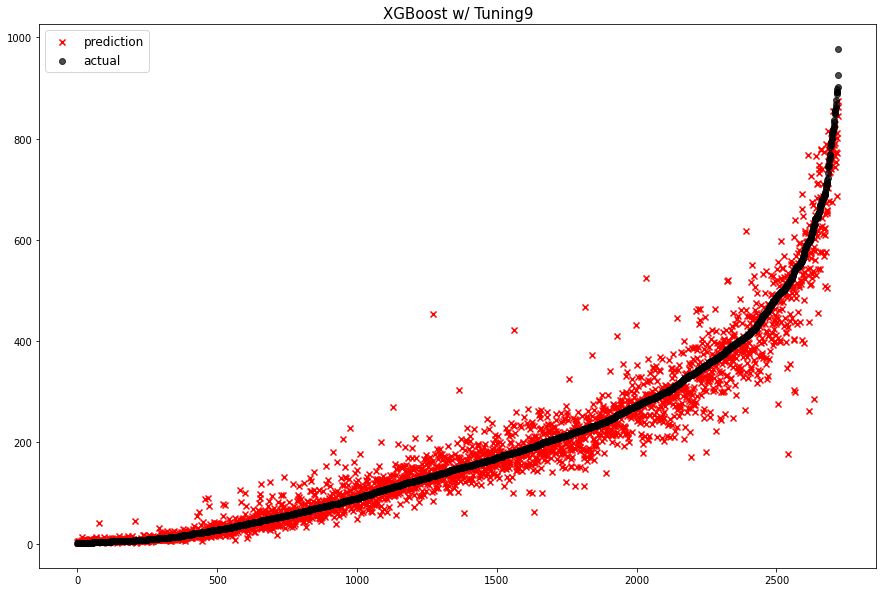

                 model     error
0        GradientBoost  0.384746
1   XGBoost w/ Tuning3  0.346558
2    XGBoost w/ Tuning  0.285223
3   XGBoost w/ Tuning4  0.284977
4   XGBoost w/ Tuning1  0.282823
5   XGBoost w/ Tuning2  0.282667
6   XGBoost w/ Tuning9  0.279512
7   XGBoost w/ Tuning7  0.279443
8   XGBoost w/ Tuning5  0.278928
9   XGBoost w/ Tuning6  0.278780
10  XGBoost w/ Tuning8  0.278780


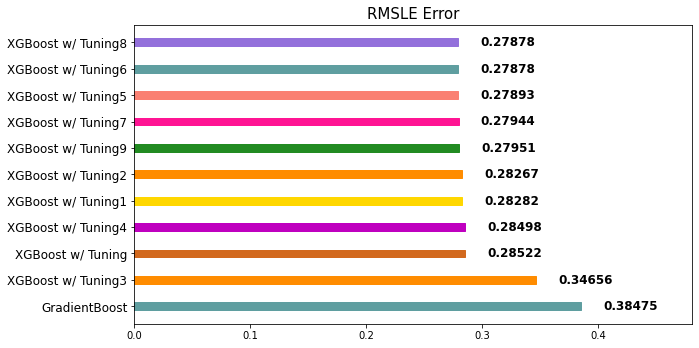

0.2795122227818665

In [144]:
# XG_boost
xgb = XGBRegressor(random_state=SEED, learning_rate=0.05, n_estimators=500, subsample=0.8, colsample_bytree=0.8, max_depth=5, n_jobs=1)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_valid)
utils.plot_error('XGBoost w/ Tuning9', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid), np.expm1(pred))

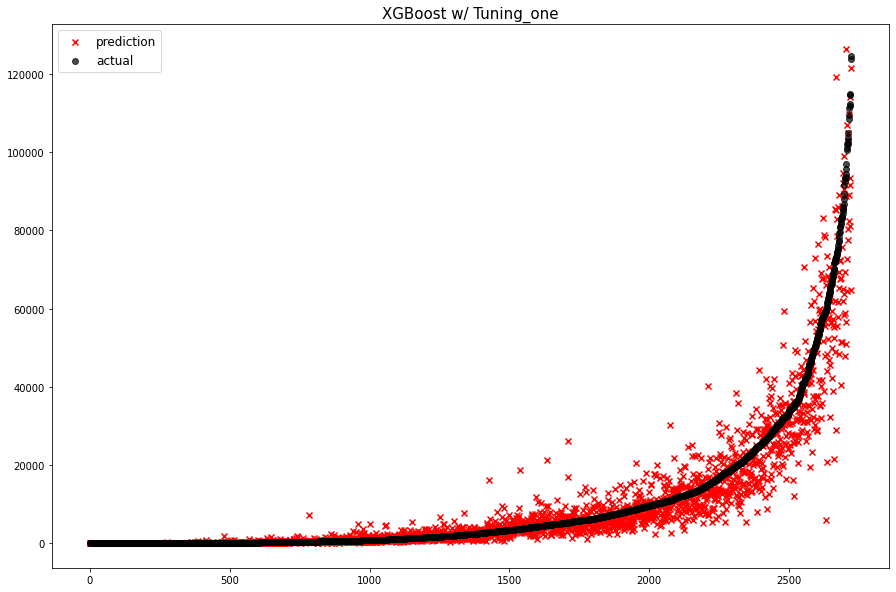

                   model     error
0  XGBoost w/ Tuning_one  0.606213
1          GradientBoost  0.532869


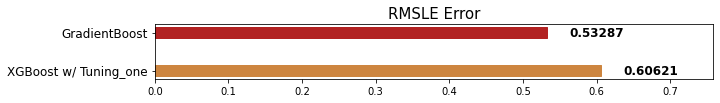

0.6062133864451534

In [32]:
# XG_boost -- 분할합계
model1 = XGBRegressor(random_state=SEED, learning_rate=0.05, n_estimators=500, subsample=0.8, colsample_bytree=0.8, max_depth=5, n_jobs=1)
model1.fit(x_train, y_train_one)
pred1 = model1.predict(x_valid)
pred1[pred1 < 0] = 0

model2 = XGBRegressor(random_state=SEED, learning_rate=0.05, n_estimators=500, subsample=0.8, colsample_bytree=0.8, max_depth=5, n_jobs=1)
model2.fit(x_train, y_train_mem)
pred2 = model2.predict(x_valid)
pred2[pred2 < 0] = 0

utils.plot_error('XGBoost w/ Tuning_one', np.expm1(y_valid_one+y_valid_mem), np.expm1(pred1+pred2))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid_one+y_valid_mem), np.expm1(pred1+pred2))

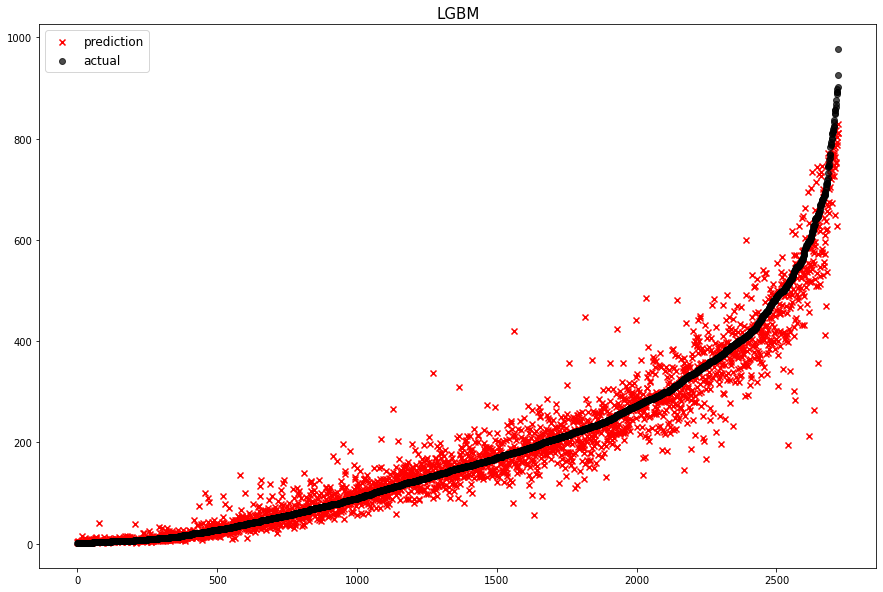

                model     error
0     Poly ElasticNet  0.881301
1       GradientBoost  0.387674
2        RandomForest  0.326039
3  XGBoost w/ Tuning1  0.318603
4             XGBoost  0.308948
5      LGBM w/ Tuning  0.303643
6                LGBM  0.287336
7   Stacking Ensemble  0.286000
8   XGBoost w/ Tuning  0.276392


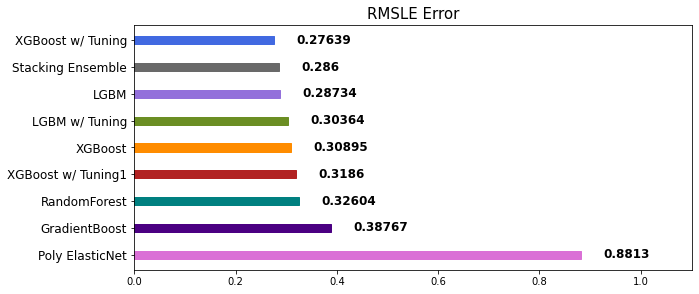

0.2873357728602448

In [402]:
# LGBM
model = LGBMRegressor(random_state=SEED, n_jobs=1)
model.fit(x_train, y_train)
pred = model.predict(x_valid)
utils.plot_error('LGBM', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid), np.expm1(pred))

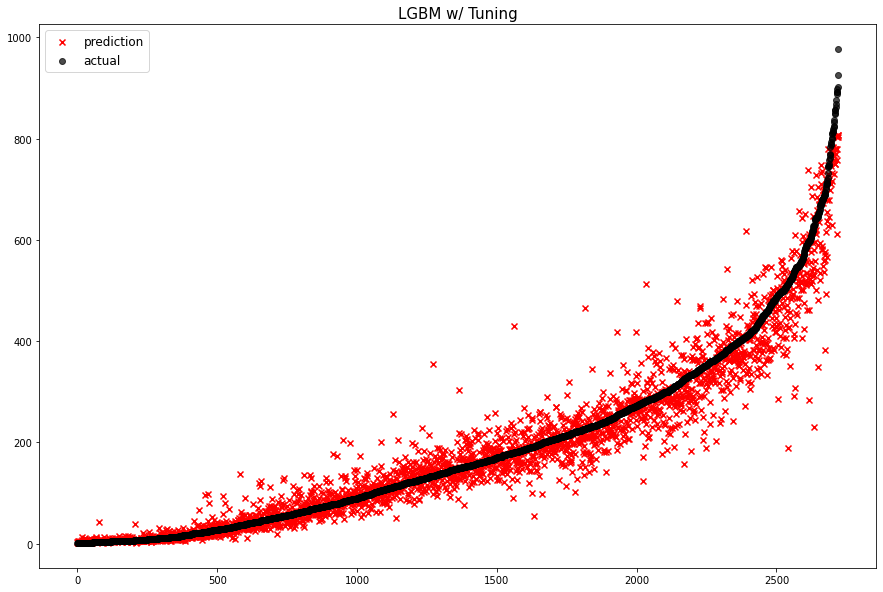

                model     error
0     Poly ElasticNet  0.881301
1       GradientBoost  0.387674
2        RandomForest  0.326039
3  XGBoost w/ Tuning1  0.318603
4             XGBoost  0.308948
5                LGBM  0.287336
6   Stacking Ensemble  0.286000
7      LGBM w/ Tuning  0.285224
8   XGBoost w/ Tuning  0.276392


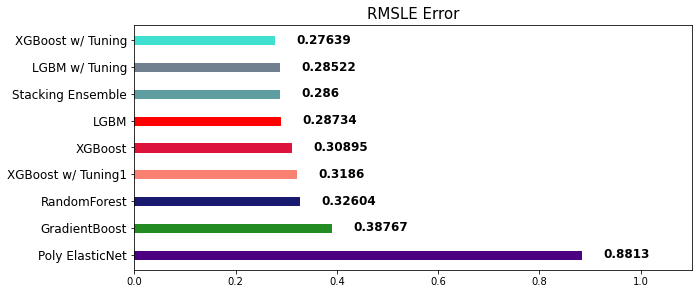

0.2852235410298424

In [403]:
# LGBM
lgbm = LGBMRegressor(random_state=SEED, learning_rate=0.01, n_estimators=1000, colsample_bytree=0.9, n_jobs=1)
lgbm.fit(x_train, y_train)
pred = lgbm.predict(x_valid)
utils.plot_error('LGBM w/ Tuning', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid), np.expm1(pred))

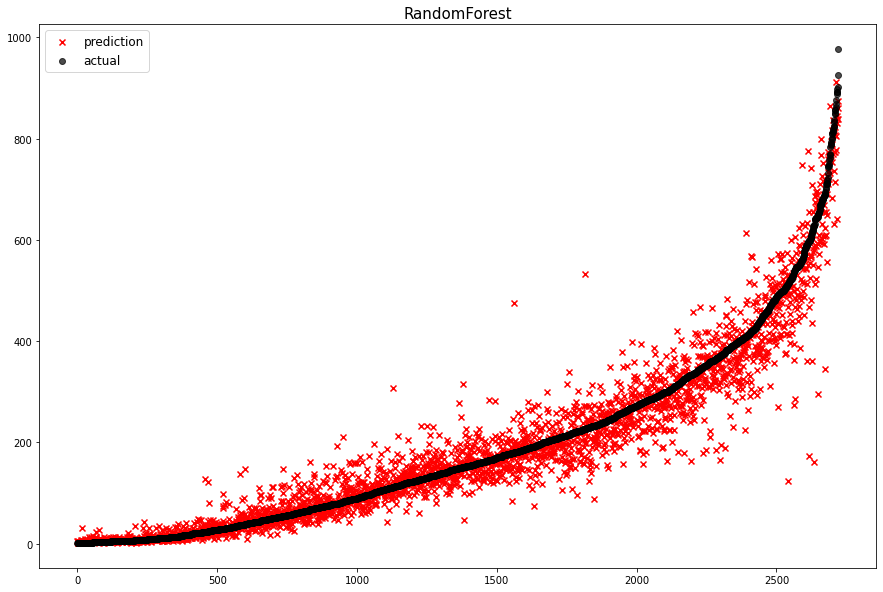

               model     error
0    Poly ElasticNet  0.881301
1      GradientBoost  0.387674
2       RandomForest  0.326039
3            XGBoost  0.308948
4               LGBM  0.305548
5  Stacking Ensemble  0.305118
6     LGBM w/ Tuning  0.303643
7  XGBoost w/ Tuning  0.296959


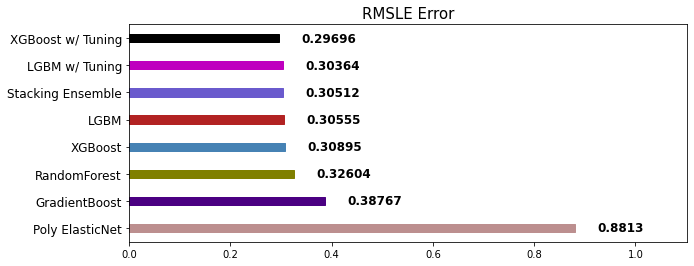

0.32603866885597155

In [268]:
# Randomforest
rfr = RandomForestRegressor(random_state=SEED)
rfr.fit(x_train, y_train)
pred = rfr.predict(x_valid)
utils.plot_error('RandomForest', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid), np.expm1(pred))

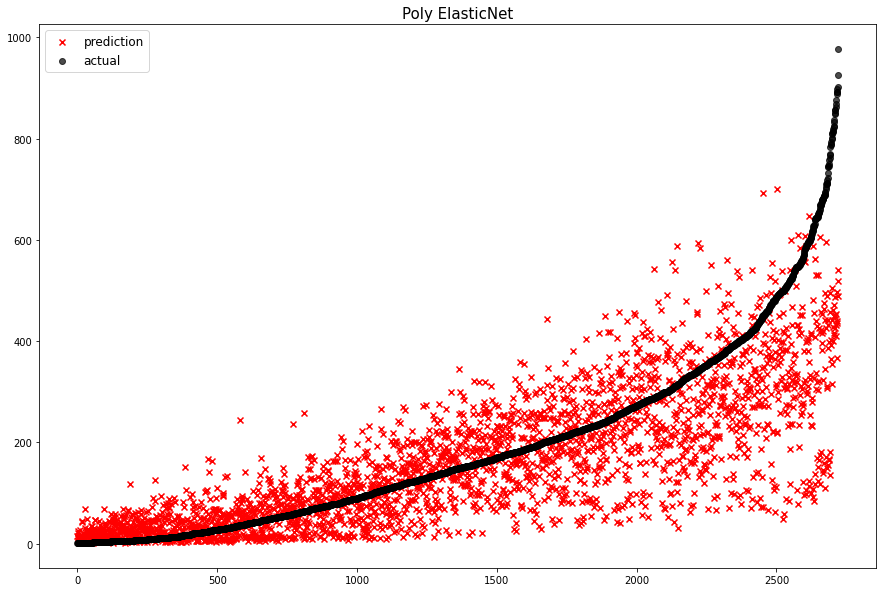

                model     error
0     Poly ElasticNet  0.844259
1       GradientBoost  0.387674
2        RandomForest  0.326039
3  XGBoost w/ Tuning1  0.318603
4             XGBoost  0.308948
5                LGBM  0.287336
6   Stacking Ensemble  0.286000
7      LGBM w/ Tuning  0.285224
8   XGBoost w/ Tuning  0.276392


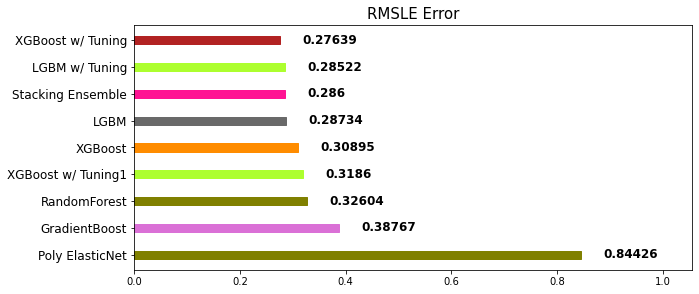

0.8442592266867325

In [404]:
poly_pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    ElasticNet(alpha=0.1, l1_ratio=0.8)
)
poly_pipeline.fit(x_train, y_train)
pred = poly_pipeline.predict(x_valid)
utils.plot_error('Poly ElasticNet', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid), np.expm1(pred))

### Stacking

In [398]:
from sklearn.ensemble import StackingRegressor

stack_models = [
    ('elasticnet', poly_pipeline), 
    ('randomforest', rfr), 
    ('gbr', gbr),
    ('lgbm', lgbm),
]

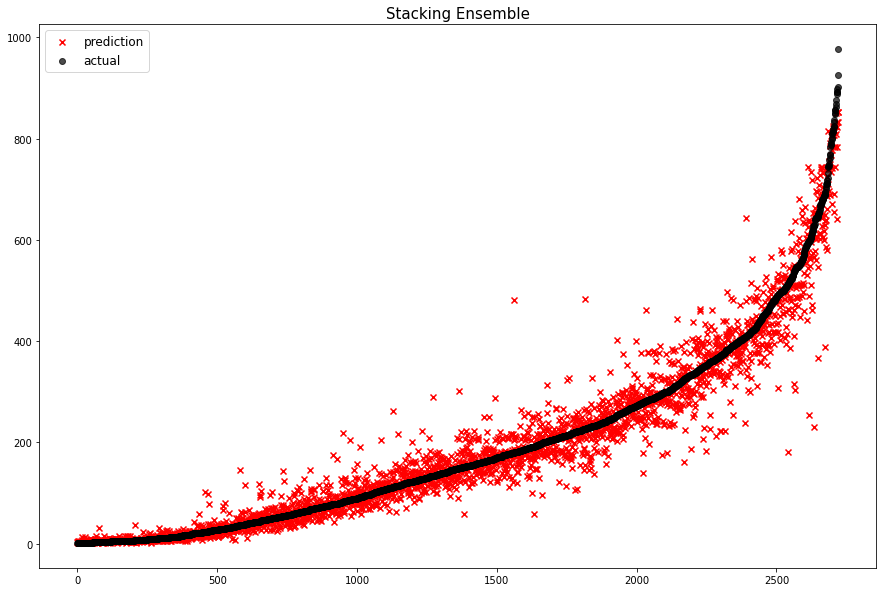

                model     error
0     Poly ElasticNet  0.881301
1       GradientBoost  0.387674
2        RandomForest  0.326039
3  XGBoost w/ Tuning1  0.318603
4             XGBoost  0.308948
5                LGBM  0.305548
6      LGBM w/ Tuning  0.303643
7   Stacking Ensemble  0.286000
8   XGBoost w/ Tuning  0.276392


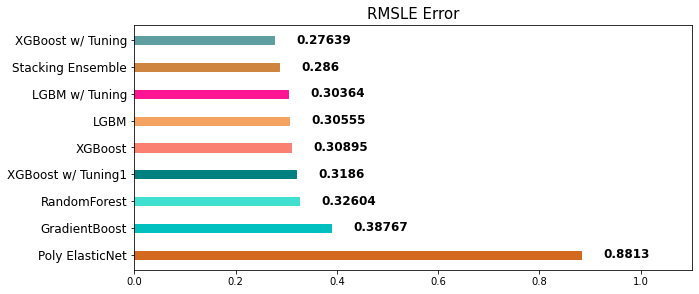

0.2860003850189356

In [399]:
model = StackingRegressor(stack_models, final_estimator=xgb, n_jobs=1)
model.fit(x_train, y_train)
pred = model.predict(x_valid)
utils.plot_error('Stacking Ensemble', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid), np.expm1(pred))

## GridSearchCV

In [66]:
from sklearn.model_selection import GridSearchCV

In [67]:
params = {
    'n_estimators': [500, 1000], 
    'learning_rate': [0.1, 0.05, 0.01], 
    'colsample_bytree': [0.7, 0.8, 0.9], 
    'subsample': [0.8, 0.9],
    'max_depth': [3, 5, 7]
}

In [68]:
grid_search = GridSearchCV(XGBRegressor(), params, n_jobs=1, cv=3, scoring='neg_mean_squared_error')

In [69]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

In [70]:
abs(grid_search.best_score_)

0.08370501085061195

In [71]:
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 5,
 'n_estimators': 1000,
 'subsample': 0.9}

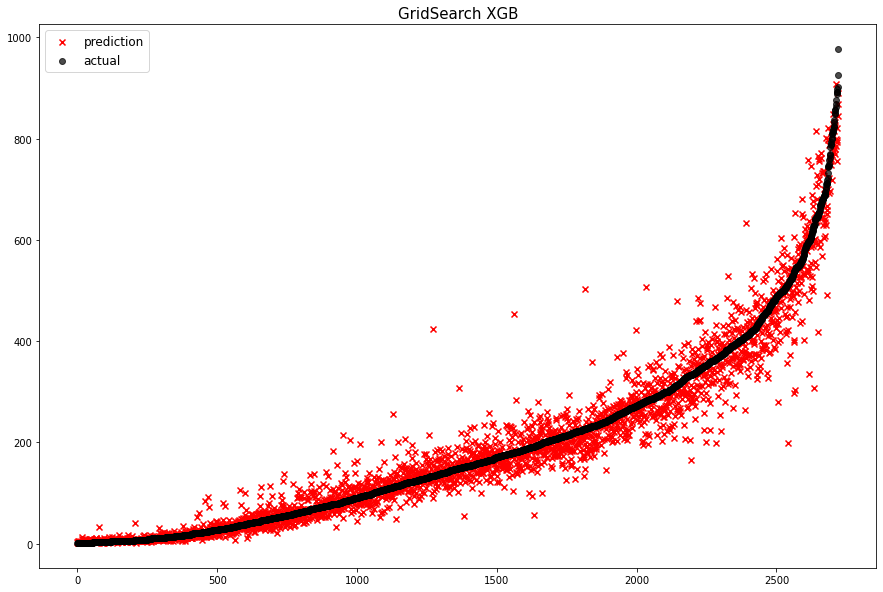

                   model     error
0  XGBoost w/ Tuning_one  0.606213
1          GradientBoost  0.532869
2         GridSearch XGB  0.277750


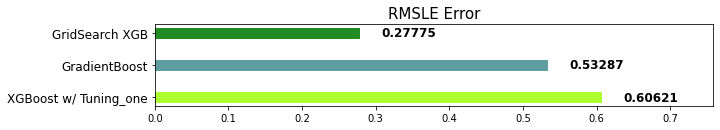

0.2777496707171978

In [72]:
model = XGBRegressor(**grid_search.best_params_,random_state=SEED)
model.fit(x_train, y_train)
pred = model.predict(x_valid)
utils.plot_error('GridSearch XGB', np.expm1(y_valid), np.expm1(pred))

RMSLE = lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred))
RMSLE(np.expm1(y_valid), np.expm1(pred))

## 시각화 샘플 코드

In [198]:
# 시각화 차트 초기화
utils.clear_error()